In [1]:
from pyspark.sql import SparkSession
import pyspark.sql as pysparksql
import pandas 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
#Creating SparkSession and also loading the csv data
startTimeQuery = time.clock()
spark=SparkSession.builder.appName("HeartStroke").getOrCreate()
heart_stroke_train=spark.read.csv("train_2v.csv",inferSchema=True,header=True)
testSet=spark.read.csv("test_2v.csv",inferSchema=True,header=True)

In [3]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        
        for row in rdd.collect():
            
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [4]:
#Printing the schema 
heart_stroke_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [5]:
heart_stroke_train.dtypes

[('id', 'int'),
 ('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'double'),
 ('smoking_status', 'string'),
 ('stroke', 'int')]

In [6]:
heart_stroke_train.toPandas().head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,None,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,None,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,None,0


In [7]:
heart_stroke_train=heart_stroke_train.withColumnRenamed("stroke","label")

In [8]:
heart_stroke_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- label: integer (nullable = true)



In [9]:
testSet.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)



In [10]:
#Printing the dimensions of the dataset(rows,columns)
heart_stroke_train.count(),len(heart_stroke_train.columns)

(43400, 12)

In [11]:
testSet.count(),len(testSet.columns)

(18601, 11)

In [12]:
heart_stroke_train.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+-----+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|label|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+-----+
|30669|  Male| 3.0|           0|            0|          No|     children|         Rural|            95.12|18.0|           null|    0|
|30468|  Male|58.0|           1|            0|         Yes|      Private|         Urban|            87.96|39.2|   never smoked|    0|
|16523|Female| 8.0|           0|            0|          No|      Private|         Urban|           110.89|17.6|           null|    0|
|56543|Female|70.0|           0|            0|         Yes|      Private|         Rural|            69.04|35.9|formerly smoked|    0|
|46136|  Male|14.0|           0|            0|          No| Ne

In [13]:
testSet.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|36306|  Male|80.0|           0|            0|         Yes|      Private|         Urban|            83.84|21.1|formerly smoked|
|61829|Female|74.0|           0|            1|         Yes|Self-employed|         Rural|            179.5|26.0|formerly smoked|
|14152|Female|14.0|           0|            0|          No|     children|         Rural|            95.16|21.2|           null|
|12997|  Male|28.0|           0|            0|          No|      Private|         Urban|            94.76|23.4|           null|
|40801|Female|63.0|           0|            0|         Yes|     Govt_job|         Rural|            83.5

+-----+-----+
|label|count|
+-----+-----+
|    1|  783|
|    0|42617|
+-----+-----+



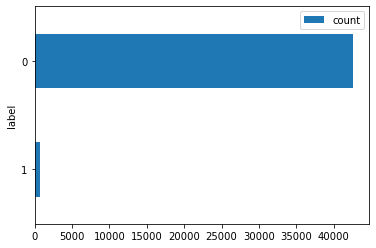

In [14]:
heart_stroke_train.groupBy('label').count().show()
df_heart=heart_stroke_train.groupBy('label').count().toPandas()
df_heart.plot(x='label',y='count',kind='barh')

# Handling the Imbalanced dataset

As we can see that there are more records with label '0' and very few compared to label '1' class. This should be fixed before proceeding forward

In [15]:
heart_stroke_train_pos=heart_stroke_train.filter(heart_stroke_train["label"]==1)
heart_stroke_train_neg=heart_stroke_train.filter(heart_stroke_train["label"]==0)

In [16]:
from pyspark.sql.functions import col
heart_stroke_train_pos= heart_stroke_train_pos.where(col('label')==1).sample(True,(42617/783)*3.0, seed = 2018)
heart_stroke_train_neg=heart_stroke_train_neg.where(col('label')==0)
heart_stroke_train = heart_stroke_train_neg.union(heart_stroke_train_pos)

In [17]:
heart_stroke_train_neg=heart_stroke_train_neg.where(col('label')==0).sample(True, 3.0, seed = 2018)
heart_stroke_train = heart_stroke_train_neg.union(heart_stroke_train_pos)

+-----+------+
|label| count|
+-----+------+
|    1|128078|
|    0|128061|
+-----+------+



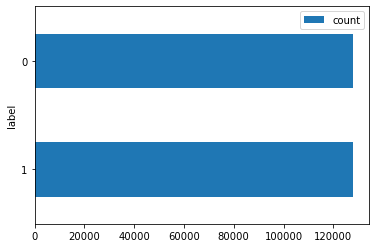

In [18]:
heart_stroke_train.groupBy('label').count().show()
df_heart=heart_stroke_train.groupBy('label').count().toPandas()
df_heart.plot(x='label',y='count',kind='barh')

In [19]:
heart_stroke_train.createOrReplaceTempView('heart')
testSet.createOrReplaceTempView('test')

+-------------+-----+
|    work_type|count|
+-------------+-----+
|      Private|72171|
|Self-employed|40901|
|     Govt_job|14695|
|     children|  311|
+-------------+-----+



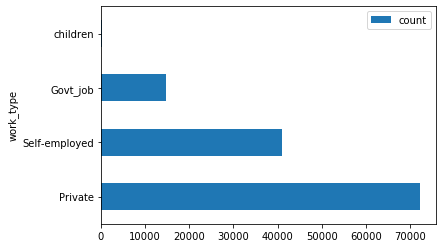

In [20]:
#We are finding which work type is more harmful. We are can see that people in private Jobs have more strokes 
heart_stroke_train.filter(heart_stroke_train['label']==1).groupBy('work_type').count().orderBy('count',ascending=False).show()
heart_stroke_train_plot=heart_stroke_train.filter(heart_stroke_train['label']==1).groupBy('work_type').count().orderBy('count',ascending=False)
data=heart_stroke_train_plot.toPandas()
data.plot(x='work_type',y='count',kind='barh')

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|   never smoked|46593|
|formerly smoked|35945|
|           null|23628|
|         smokes|21912|
+---------------+-----+



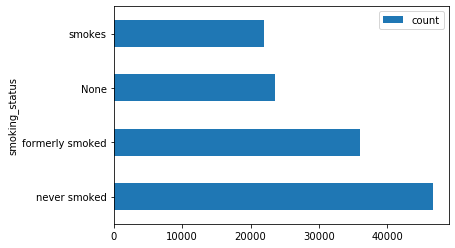

In [21]:
heart_stroke_train.filter(heart_stroke_train['label']==1).groupBy('smoking_status').count().orderBy('count',ascending=False).show()
smoking_status_plot=heart_stroke_train.filter(heart_stroke_train['label']==1).groupBy('smoking_status').count().orderBy('count',ascending=False)
data=smoking_status_plot.toPandas()
data.plot(x='smoking_status',y='count',kind='barh')

Since we can see that we have the 'null' value in the smoke type. It will be better to replace it another parameter called 'No Info' as it will look cleaner

In [22]:
updated_info=heart_stroke_train.fillna('No Info',subset=['smoking_status'])
updated_info.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+-----+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|label|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+-----+
|30669|  Male| 3.0|           0|            0|          No|     children|         Rural|            95.12|18.0|        No Info|    0|
|30468|  Male|58.0|           1|            0|         Yes|      Private|         Urban|            87.96|39.2|   never smoked|    0|
|30468|  Male|58.0|           1|            0|         Yes|      Private|         Urban|            87.96|39.2|   never smoked|    0|
|16523|Female| 8.0|           0|            0|          No|      Private|         Urban|           110.89|17.6|        No Info|    0|
|16523|Female| 8.0|           0|            0|          No|   

In [23]:
testSet=testSet.fillna('No Info',subset=['smoking_status'])
testSet.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|36306|  Male|80.0|           0|            0|         Yes|      Private|         Urban|            83.84|21.1|formerly smoked|
|61829|Female|74.0|           0|            1|         Yes|Self-employed|         Rural|            179.5|26.0|formerly smoked|
|14152|Female|14.0|           0|            0|          No|     children|         Rural|            95.16|21.2|        No Info|
|12997|  Male|28.0|           0|            0|          No|      Private|         Urban|            94.76|23.4|        No Info|
|40801|Female|63.0|           0|            0|         Yes|     Govt_job|         Rural|            83.5

We can now see that we null value in the smoking_status column has been replaced with No Info.

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|   never smoked|46593|
|formerly smoked|35945|
|        No Info|23628|
|         smokes|21912|
+---------------+-----+



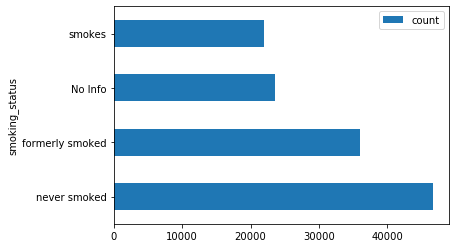

In [24]:
smoking_status_plot=updated_info.filter(updated_info['label']==1).groupBy('smoking_status').count().orderBy('count',ascending=False)
updated_info.filter(updated_info['label']==1).groupBy('smoking_status').count().orderBy('count',ascending=False).show()
data=smoking_status_plot.toPandas()
data.plot(x='smoking_status',y='count',kind='barh')

+----+-----+
| age|count|
+----+-----+
|82.0| 5829|
|81.0| 7166|
|80.0| 7986|
|79.0|11350|
|78.0| 9512|
|77.0| 4018|
|76.0| 3865|
|75.0| 3715|
|74.0| 3930|
|73.0| 2418|
|72.0| 3442|
|71.0| 3167|
|70.0| 4078|
|69.0| 3266|
|68.0| 3405|
|67.0| 3753|
|66.0| 2733|
|65.0| 2989|
|64.0| 1356|
|63.0| 2947|
+----+-----+
only showing top 20 rows



<Figure size 2160x1440 with 0 Axes>

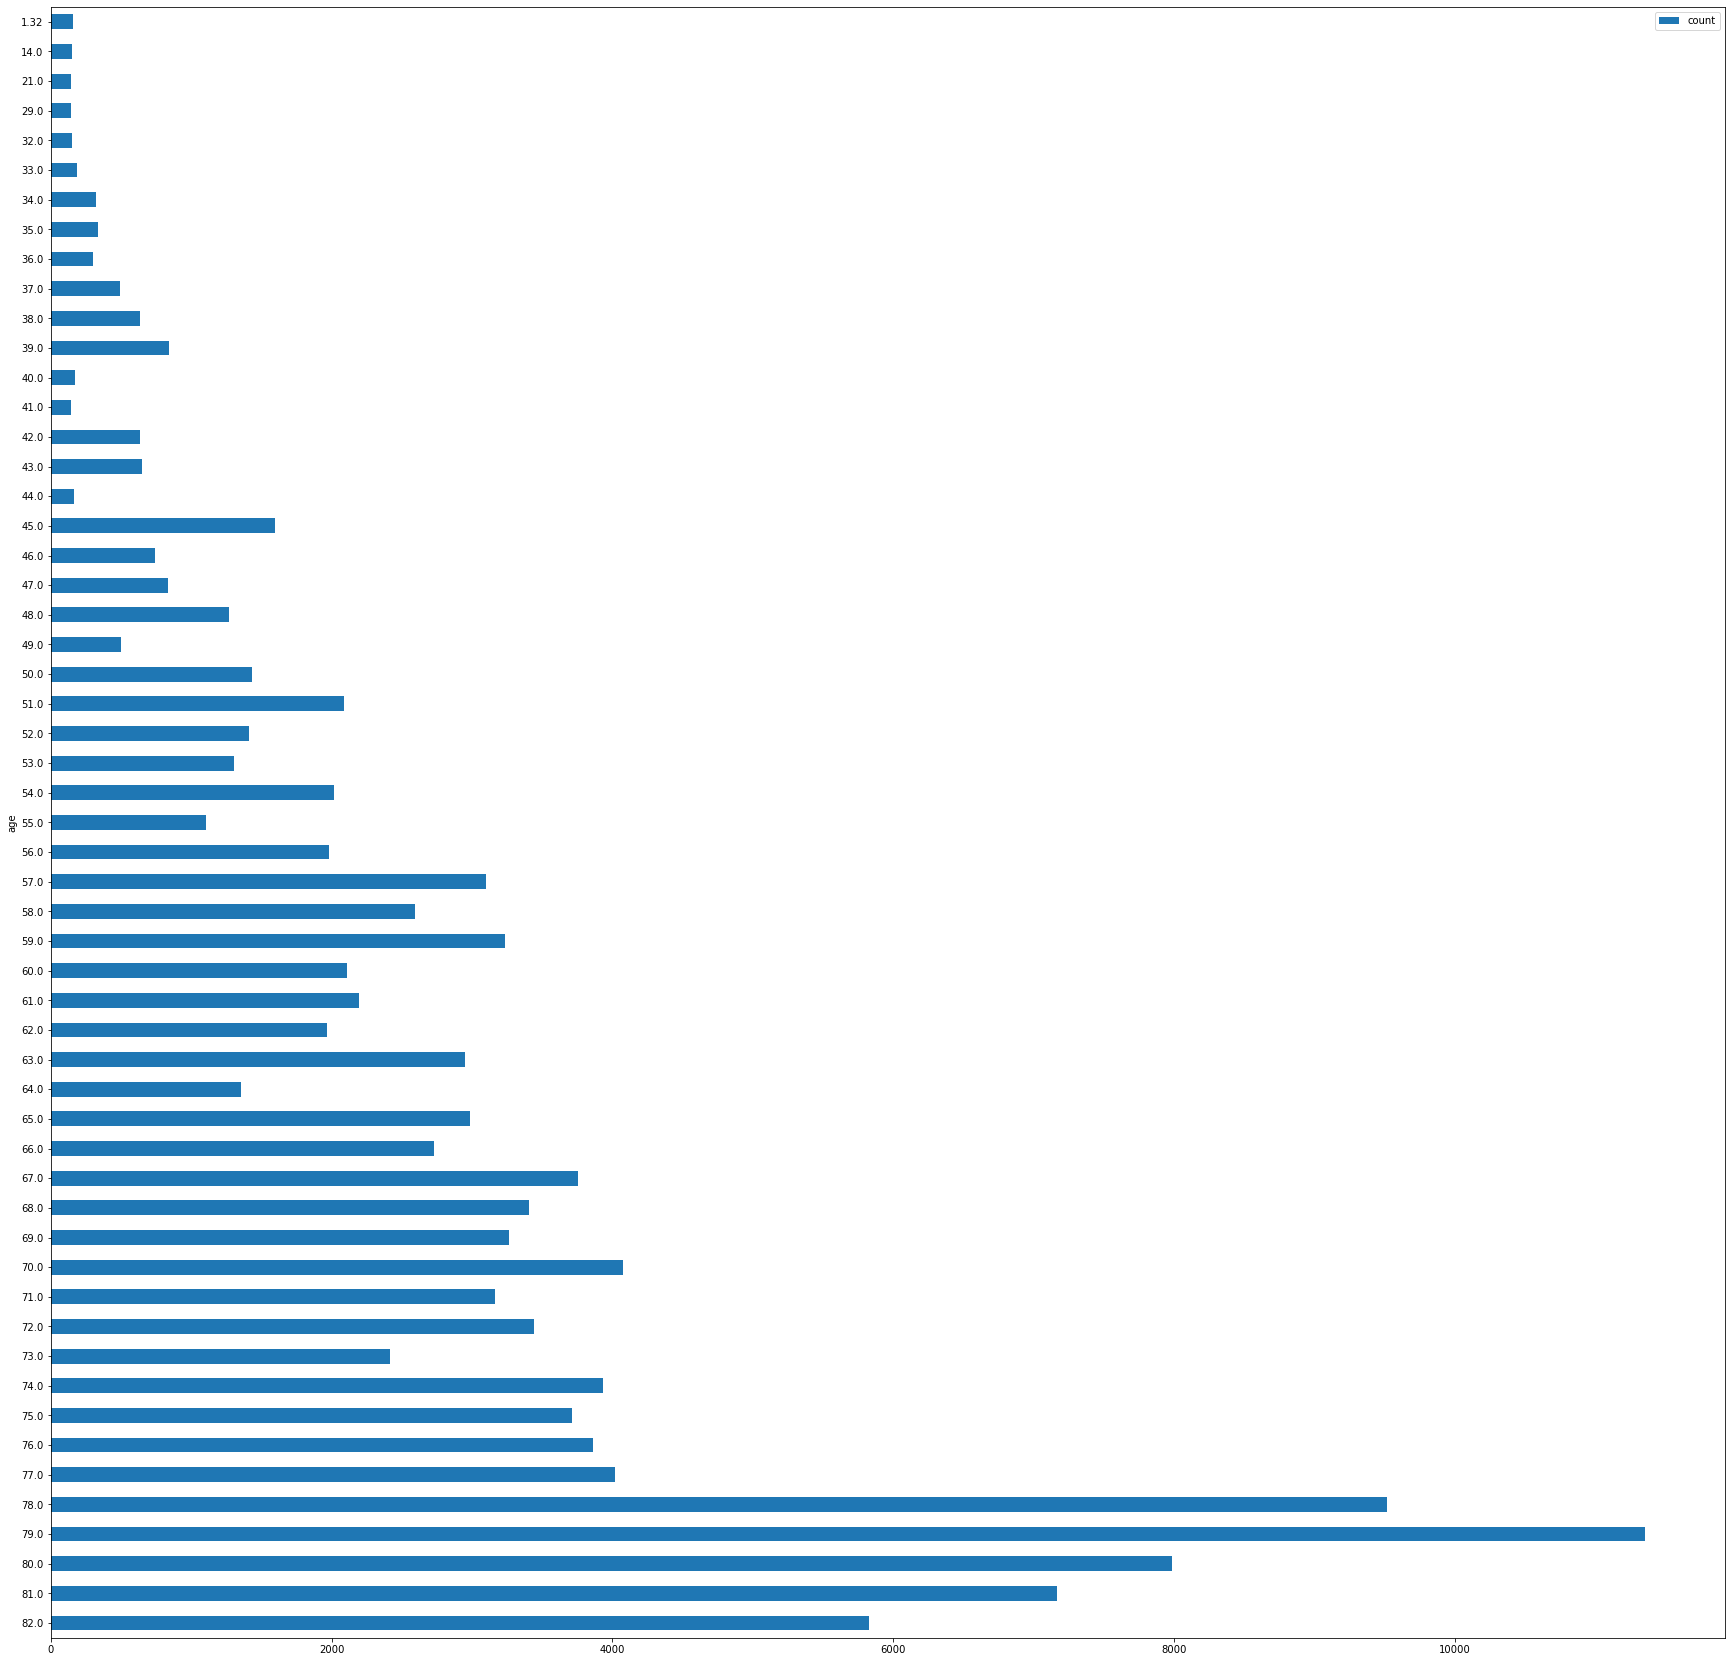

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
updated_info.filter(updated_info['label']==1).groupBy('age').count().orderBy('age',ascending=False).show()
plt.figure(figsize=(30, 20))
#sns.barplot(x='age',y='count',data=updated_info.filter(updated_info['stroke']==1).groupBy('age').count().orderBy('age',ascending=False).toPandas())
data=updated_info.filter(updated_info['label']==1).groupBy('age').count().orderBy('age',ascending=False).toPandas()
data.plot(x='age',y='count',kind='barh',figsize=(30, 30))

+------------+------+
|ever_married| count|
+------------+------+
|         Yes|115023|
|          No| 13055|
+------------+------+



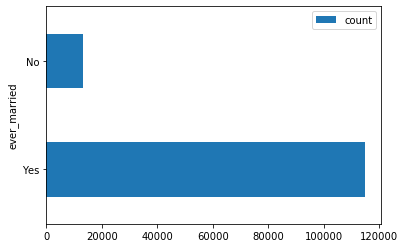

In [26]:
updated_info.filter(updated_info['label']==1).groupBy('ever_married').count().orderBy('ever_married',ascending=False).show()
data=updated_info.filter(updated_info['label']==1).groupBy('ever_married').count().orderBy('ever_married',ascending=False).toPandas()
data.plot(x='ever_married',y='count',kind='barh')

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban|65082|
|         Rural|62996|
+--------------+-----+



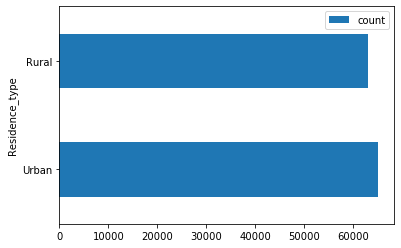

In [27]:
updated_info.filter(updated_info['label']==1).groupBy('Residence_type').count().orderBy('Residence_type',ascending=False).show()
data=updated_info.filter(updated_info['label']==1).groupBy('Residence_type').count().orderBy('Residence_type',ascending=False).toPandas()
data.plot(x='Residence_type',y='count',kind='barh')

In [28]:
updated_info.filter(updated_info['label']==1).select('bmi').distinct().show()

+----+
| bmi|
+----+
|26.7|
|47.5|
|15.4|
|37.1|
|25.1|
|32.3|
|24.7|
|50.9|
|44.8|
|26.4|
|46.4|
|23.8|
|24.9|
|37.4|
|31.7|
|35.6|
|36.2|
|31.1|
|26.6|
|23.9|
+----+
only showing top 20 rows



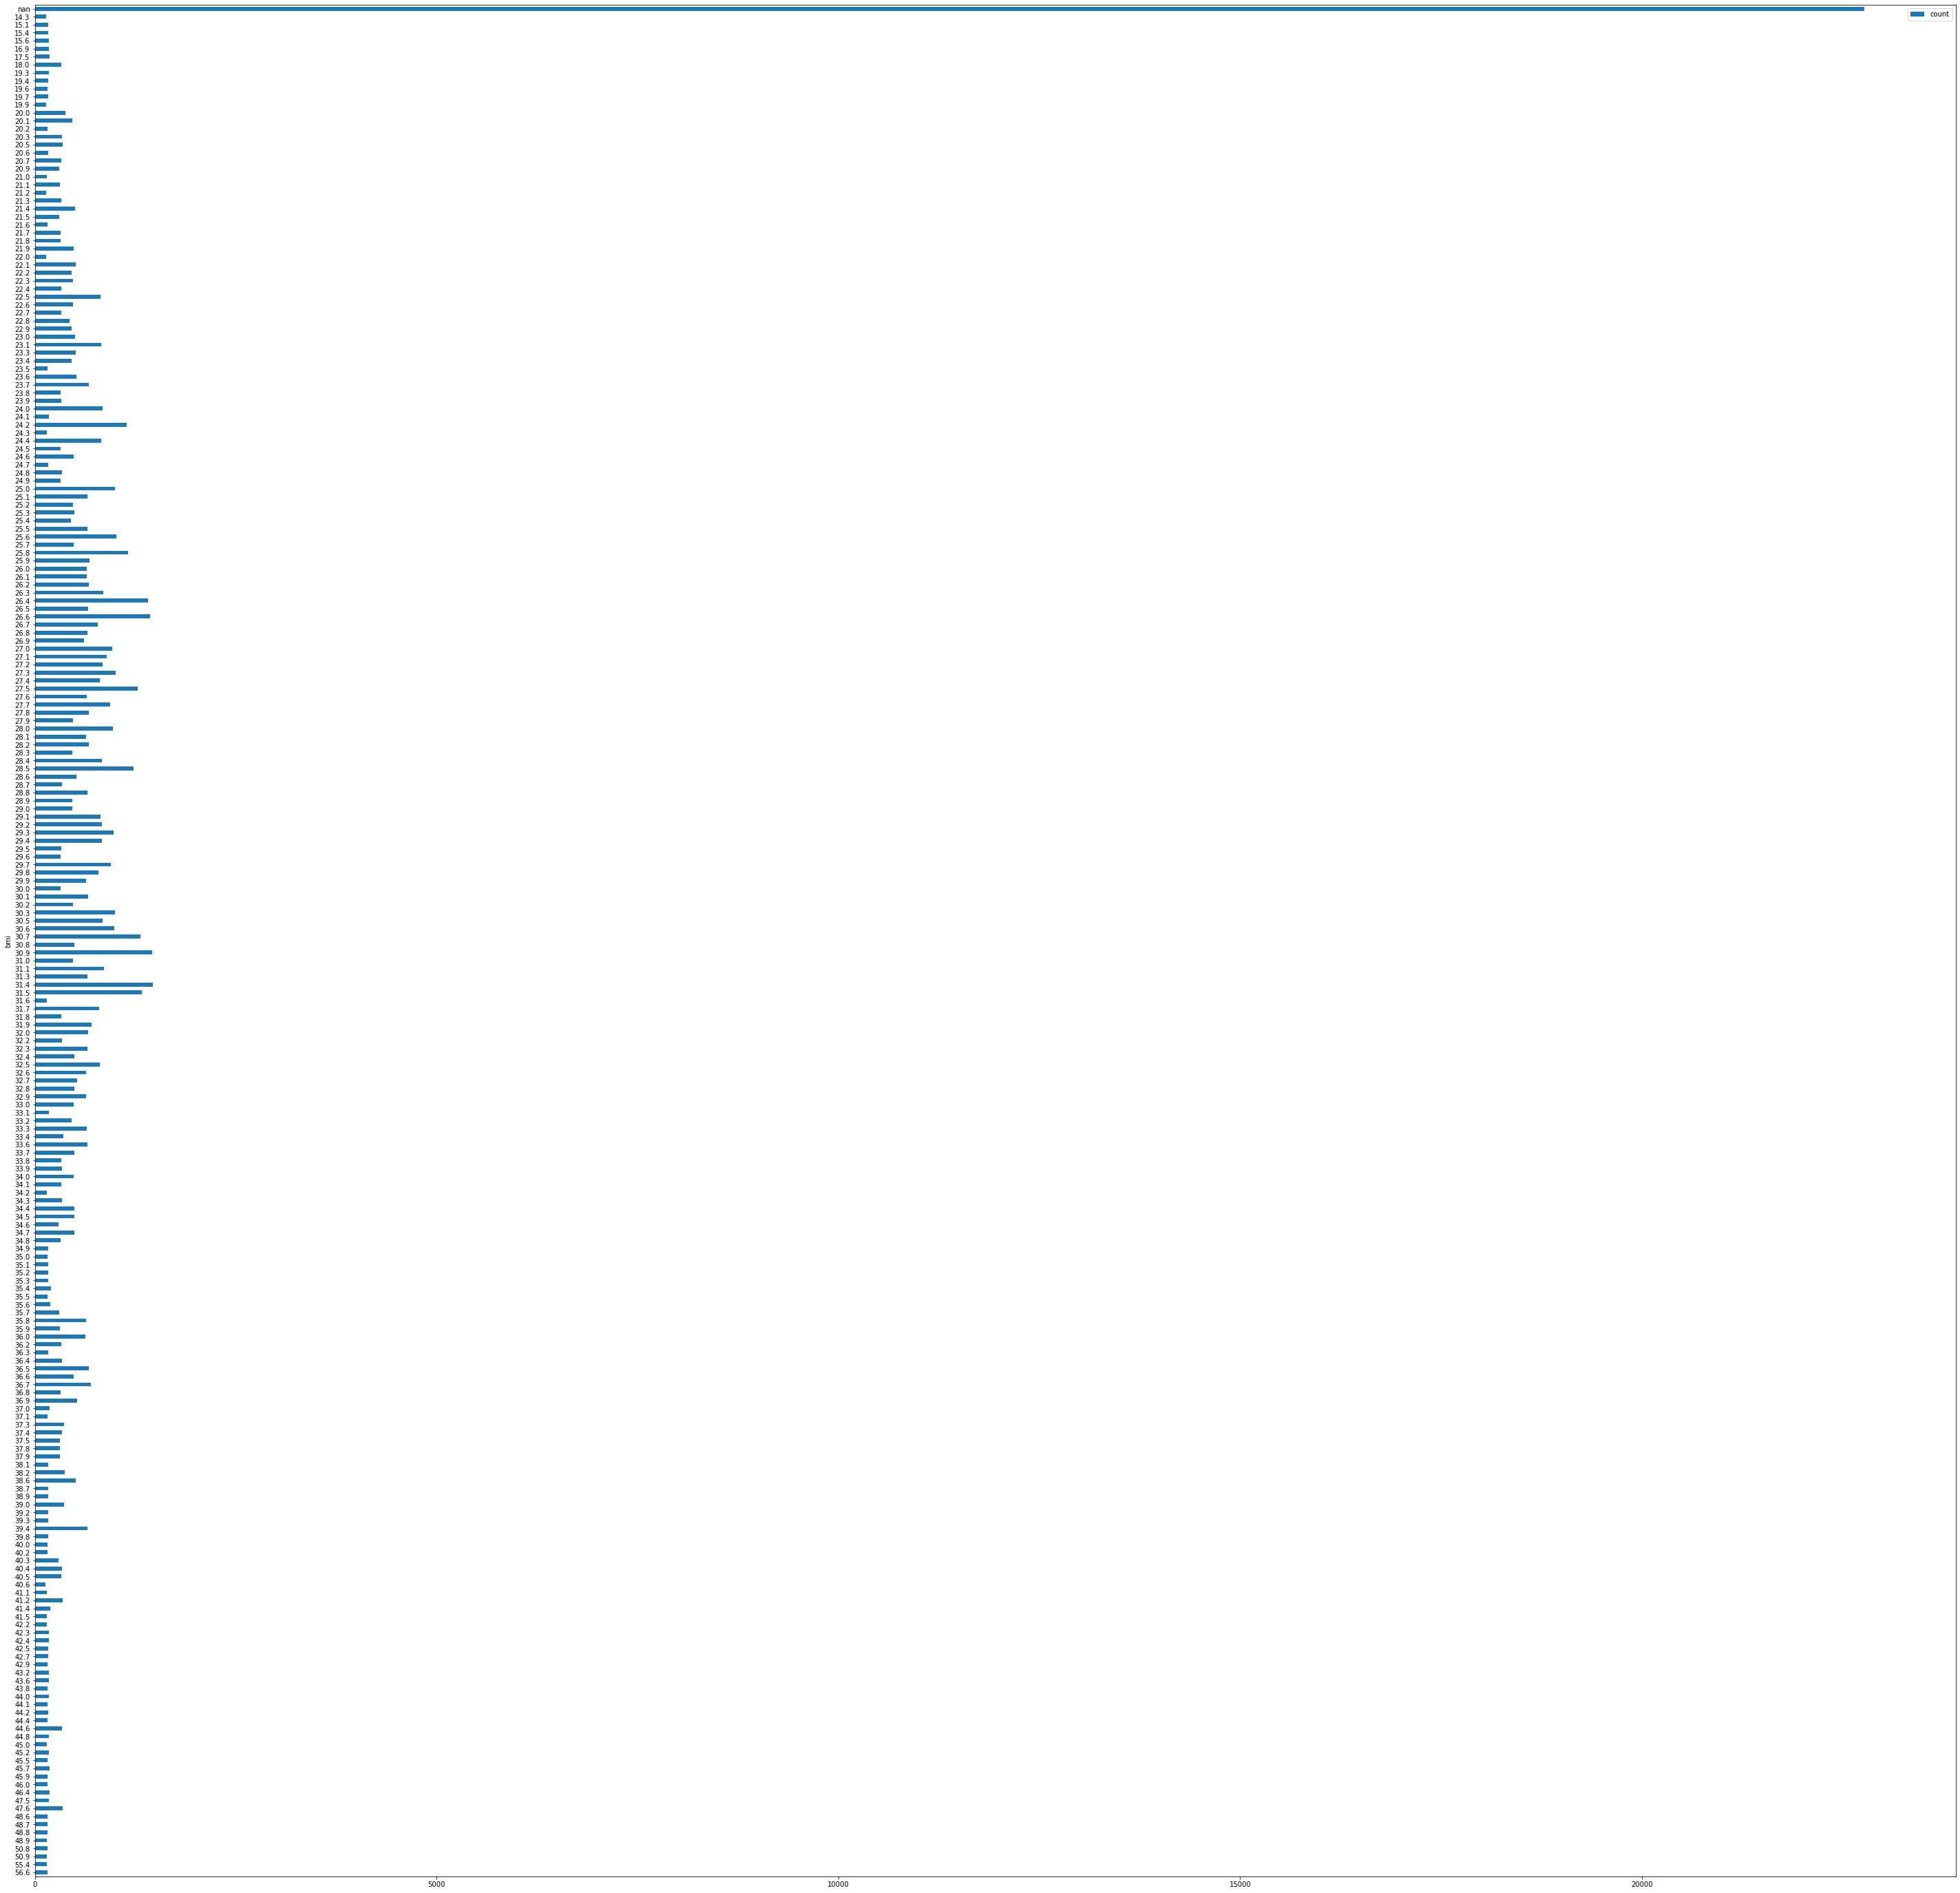

In [29]:
data_df=updated_info.filter(updated_info['label']==1).groupBy('bmi').count().orderBy('bmi',ascending=False).toPandas()
data_df.plot(x='bmi',y='count',kind='barh',figsize=(50, 50))

In [30]:
testSet.select('bmi').show()

+----+
| bmi|
+----+
|21.1|
|26.0|
|21.2|
|23.4|
|27.6|
|32.2|
|25.1|
|32.5|
|28.0|
|25.7|
|21.9|
|19.4|
|26.7|
|32.3|
|24.2|
|24.5|
|40.0|
|22.1|
|22.3|
|36.1|
+----+
only showing top 20 rows



We can see that there is null value in the bmi column. In the following cell we will be replacing this with mean value in the column. This is part of the data cleaning task.

In [31]:
from pyspark.sql.functions import mean
mean = updated_info.select(mean(updated_info['bmi'])).collect()
mean_bmi = mean[0][0]
updated_info = updated_info.fillna(mean_bmi,['bmi'])
updated_info.filter(updated_info['label']==1).select('bmi')

DataFrame[bmi: double]

In [32]:
testSet=testSet.na.fill(mean_bmi,['bmi'])

Now we will be able to see the effect of BMI in the number of people who get the heart stroke. 

+------------------+-----+
|               bmi|count|
+------------------+-----+
|29.202138491982318|22764|
|              31.4| 1468|
|              30.9| 1459|
|              26.6| 1438|
|              26.4| 1406|
|              31.5| 1328|
|              30.7| 1312|
|              27.5| 1276|
|              28.5| 1228|
|              25.8| 1160|
|              24.2| 1144|
|              25.6| 1016|
|              27.3| 1006|
|              25.0|  999|
|              30.3|  999|
|              30.6|  993|
|              29.3|  983|
|              28.0|  971|
|              27.0|  961|
|              29.7|  947|
+------------------+-----+
only showing top 20 rows



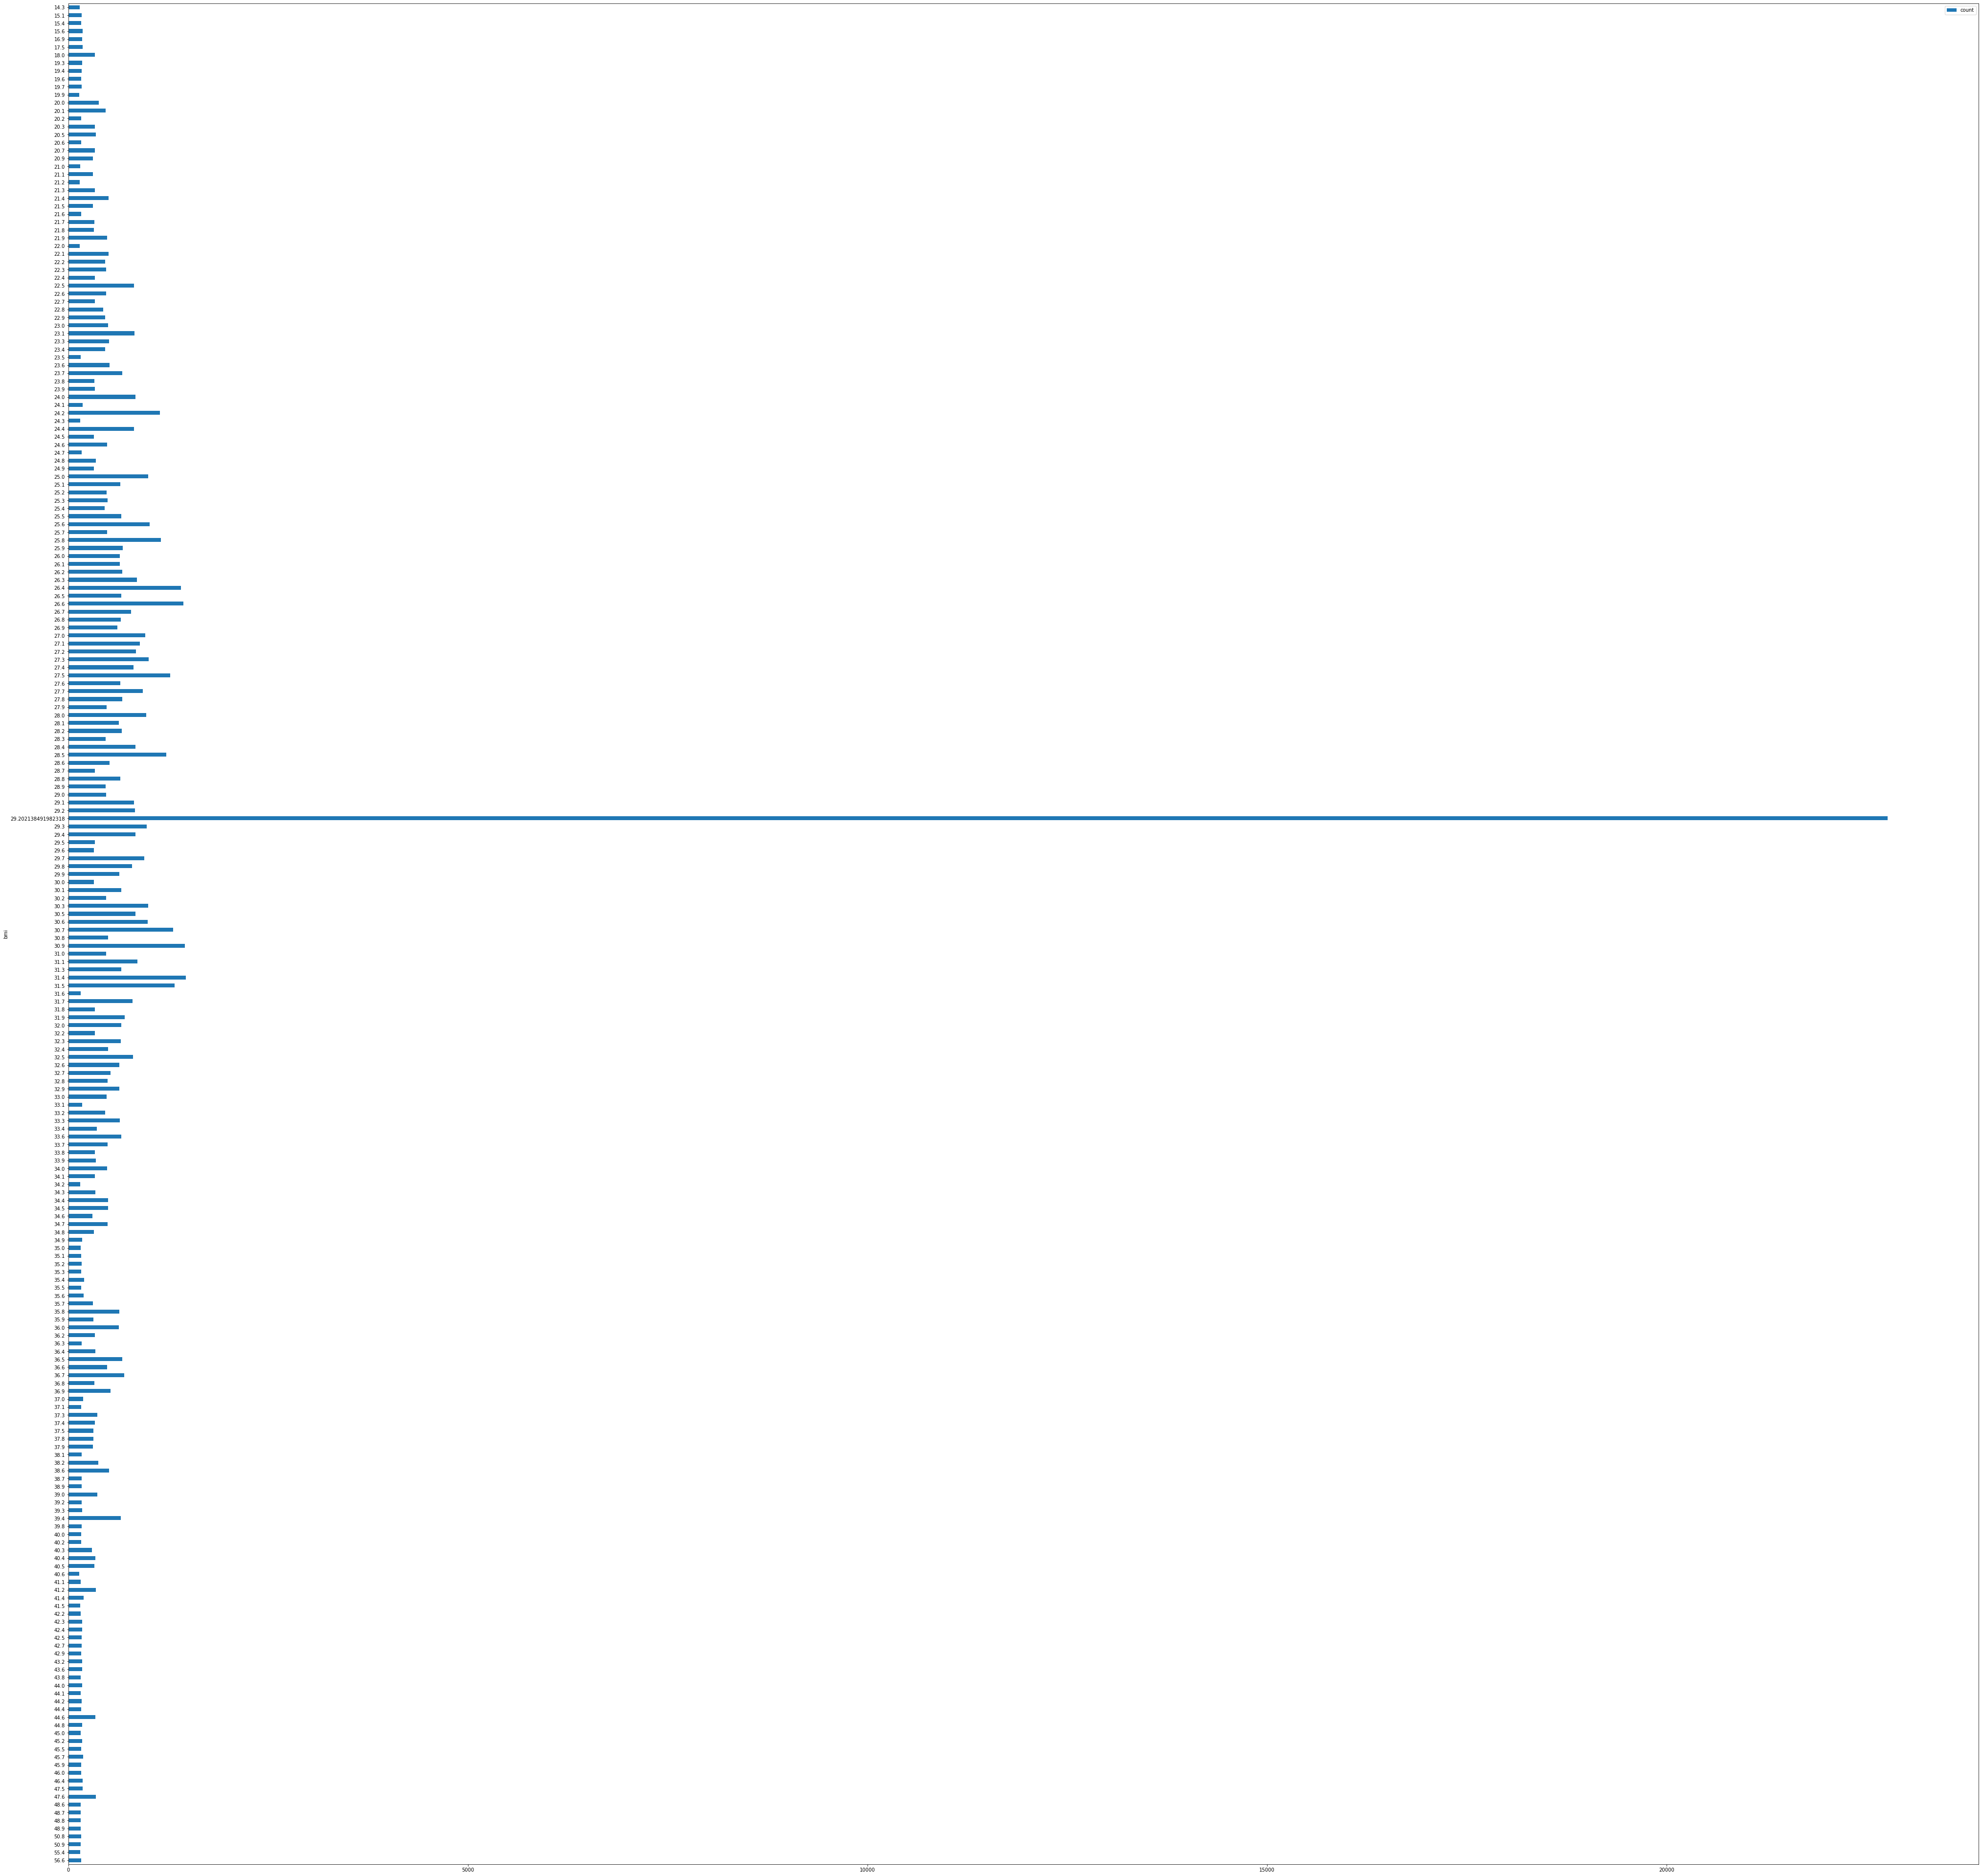

In [33]:
updated_info.filter(updated_info['label']==1).groupBy('bmi').count().orderBy('count',ascending=False).show()
data_df=updated_info.filter(updated_info['label']==1).groupBy('bmi').count().orderBy('bmi',ascending=False).toPandas()
data_df.plot(x='bmi',y='count',kind='barh',figsize=(70, 70))

We can see that people with people with higher BMI chance of getting a stroke.

In the next section we will see how many people had participated in this clinical process

+------+------------+--------------------+
|gender|gender_count|          percentage|
+------+------------+--------------------+
|Female|      146253|  57.099075111560516|
| Other|          47|0.018349411842788484|
|  Male|      109839|   42.88257547659669|
+------+------------+--------------------+



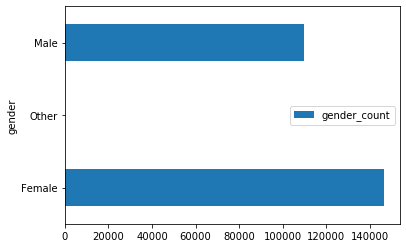

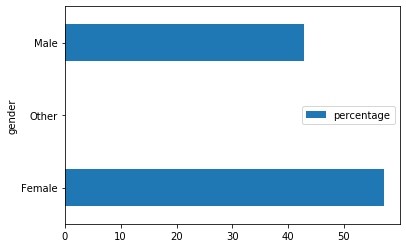

In [34]:
spark.sql("SELECT gender,count(gender) as gender_count,count(gender)*100/sum(count(gender)) over() as percentage FROM heart GROUP BY gender").show()
data=spark.sql("SELECT gender,count(gender) as gender_count,count(gender)*100/sum(count(gender)) over() as percentage FROM heart GROUP BY gender").toPandas()
data.plot(x="gender",y="gender_count",kind='barh')
data.plot(x="gender",y="percentage",kind="barh")

In [35]:
spark.sql("SELECT gender, count(gender), (COUNT(gender) * 100.0) /(SELECT count(gender) FROM heart WHERE gender == 'Male') as percentage FROM heart WHERE label = '1' and gender = 'Male' GROUP BY gender").show()
spark.sql("SELECT gender, count(gender), (COUNT(gender) * 100.0) /(SELECT count(gender) FROM heart WHERE gender == 'Female') as percentage FROM heart WHERE label = '1' and gender = 'Female' GROUP BY gender").show()

+------+-------------+-----------------+
|gender|count(gender)|       percentage|
+------+-------------+-----------------+
|  Male|        57757|52.58332650515755|
+------+-------------+-----------------+

+------+-------------+-----------------+
|gender|count(gender)|       percentage|
+------+-------------+-----------------+
|Female|        70321|48.08174875045298|
+------+-------------+-----------------+



In [36]:
updated_info.filter((updated_info['label'] == 1) & (updated_info['age'] > '50')).count()

116043

In [37]:
#StringIndexer for gender column
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
gender_indexer=StringIndexer(inputCol="gender",outputCol="genderIndex")
updated_info=gender_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["gender","genderIndex"]).show(5)

+------+-----------+
|gender|genderIndex|
+------+-----------+
|  Male|        1.0|
|  Male|        1.0|
|  Male|        1.0|
|Female|        0.0|
|Female|        0.0|
+------+-----------+
only showing top 5 rows



In [38]:
#StringIndexer for gender column for testSet
gender_indexer=StringIndexer(inputCol="gender",outputCol="genderIndex")
testSet=gender_indexer.fit(testSet).transform(testSet)
testSet.select(["gender","genderIndex"]).show(5)

+------+-----------+
|gender|genderIndex|
+------+-----------+
|  Male|        1.0|
|Female|        0.0|
|Female|        0.0|
|  Male|        1.0|
|Female|        0.0|
+------+-----------+
only showing top 5 rows



In [39]:
#OneHotEncoderEstimate for the gender column

gender_encoder=OneHotEncoderEstimator(inputCols=["genderIndex"],outputCols=["genderVec"])
model=gender_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("genderVec").take(5)


[Row(genderVec=SparseVector(2, {1: 1.0})),
 Row(genderVec=SparseVector(2, {1: 1.0})),
 Row(genderVec=SparseVector(2, {1: 1.0})),
 Row(genderVec=SparseVector(2, {0: 1.0})),
 Row(genderVec=SparseVector(2, {0: 1.0}))]

In [40]:
#OneHotEncoderEstimate for the gender column for testSet
gender_encoder=OneHotEncoderEstimator(inputCols=["genderIndex"],outputCols=["genderVec"])
model=gender_encoder.fit(testSet)
testSet=model.transform(testSet)
testSet.select("genderVec").take(5)

[Row(genderVec=SparseVector(2, {1: 1.0})),
 Row(genderVec=SparseVector(2, {0: 1.0})),
 Row(genderVec=SparseVector(2, {0: 1.0})),
 Row(genderVec=SparseVector(2, {1: 1.0})),
 Row(genderVec=SparseVector(2, {0: 1.0}))]

In [41]:
#StringIndexer for ever married column
ever_married_indexer=StringIndexer(inputCol="ever_married",outputCol="ever_marriedIndex")
updated_info=ever_married_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["ever_married","ever_marriedIndex"]).show(5)

+------------+-----------------+
|ever_married|ever_marriedIndex|
+------------+-----------------+
|          No|              1.0|
|         Yes|              0.0|
|         Yes|              0.0|
|          No|              1.0|
|          No|              1.0|
+------------+-----------------+
only showing top 5 rows



In [42]:
#StringIndexer for ever married column for testSet
ever_married_indexer=StringIndexer(inputCol="ever_married",outputCol="ever_marriedIndex")
testSet=ever_married_indexer.fit(testSet).transform(testSet)
testSet.select(["ever_married","ever_marriedIndex"]).show(5)

+------------+-----------------+
|ever_married|ever_marriedIndex|
+------------+-----------------+
|         Yes|              0.0|
|         Yes|              0.0|
|          No|              1.0|
|          No|              1.0|
|         Yes|              0.0|
+------------+-----------------+
only showing top 5 rows



In [43]:
#OneHotEncoder for ever married column

ever_married_encoder=OneHotEncoderEstimator(inputCols=["ever_marriedIndex"],outputCols=["ever_marriedVec"])
model=ever_married_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("ever_marriedVec").take(5)


[Row(ever_marriedVec=SparseVector(1, {})),
 Row(ever_marriedVec=SparseVector(1, {0: 1.0})),
 Row(ever_marriedVec=SparseVector(1, {0: 1.0})),
 Row(ever_marriedVec=SparseVector(1, {})),
 Row(ever_marriedVec=SparseVector(1, {}))]

In [44]:
#OneHotEncoder for ever married column for testSet
ever_married_encoder=OneHotEncoderEstimator(inputCols=["ever_marriedIndex"],outputCols=["ever_marriedVec"])
model=ever_married_encoder.fit(testSet)
testSet=model.transform(testSet)
testSet.select("ever_marriedVec").take(5)

[Row(ever_marriedVec=SparseVector(1, {0: 1.0})),
 Row(ever_marriedVec=SparseVector(1, {0: 1.0})),
 Row(ever_marriedVec=SparseVector(1, {})),
 Row(ever_marriedVec=SparseVector(1, {})),
 Row(ever_marriedVec=SparseVector(1, {0: 1.0}))]

In [45]:
#StringIndexer for work_type column
work_type_indexer=StringIndexer(inputCol="work_type",outputCol="work_typeIndex")
updated_info=work_type_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["work_type","work_typeIndex"]).show(5)

+---------+--------------+
|work_type|work_typeIndex|
+---------+--------------+
| children|           3.0|
|  Private|           0.0|
|  Private|           0.0|
|  Private|           0.0|
|  Private|           0.0|
+---------+--------------+
only showing top 5 rows



In [46]:
#StringIndexer for work_type column for testSet
work_type_indexer=StringIndexer(inputCol="work_type",outputCol="work_typeIndex")
testSet=work_type_indexer.fit(testSet).transform(testSet)
testSet.select(["work_type","work_typeIndex"]).show(5)

+-------------+--------------+
|    work_type|work_typeIndex|
+-------------+--------------+
|      Private|           0.0|
|Self-employed|           1.0|
|     children|           2.0|
|      Private|           0.0|
|     Govt_job|           3.0|
+-------------+--------------+
only showing top 5 rows



In [47]:
#OneHotEncoder for work_type

work_type_encoder=OneHotEncoderEstimator(inputCols=["work_typeIndex"],outputCols=["work_typeVec"])
model=work_type_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("work_typeVec").take(5)


[Row(work_typeVec=SparseVector(4, {3: 1.0})),
 Row(work_typeVec=SparseVector(4, {0: 1.0})),
 Row(work_typeVec=SparseVector(4, {0: 1.0})),
 Row(work_typeVec=SparseVector(4, {0: 1.0})),
 Row(work_typeVec=SparseVector(4, {0: 1.0}))]

In [48]:
#OneHotEncoder for work_type for testSet
work_type_encoder=OneHotEncoderEstimator(inputCols=["work_typeIndex"],outputCols=["work_typeVec"])
model=work_type_encoder.fit(testSet)
testSet=model.transform(testSet)
testSet.select("work_typeVec").take(5)

[Row(work_typeVec=SparseVector(4, {0: 1.0})),
 Row(work_typeVec=SparseVector(4, {1: 1.0})),
 Row(work_typeVec=SparseVector(4, {2: 1.0})),
 Row(work_typeVec=SparseVector(4, {0: 1.0})),
 Row(work_typeVec=SparseVector(4, {3: 1.0}))]

In [49]:
#StringIndexer for Residence_type

Residence_type_indexer=StringIndexer(inputCol="Residence_type",outputCol="ResidencetypeIndex")
updated_info=Residence_type_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["Residence_type","ResidencetypeIndex"]).show(5)

+--------------+------------------+
|Residence_type|ResidencetypeIndex|
+--------------+------------------+
|         Rural|               1.0|
|         Urban|               0.0|
|         Urban|               0.0|
|         Urban|               0.0|
|         Urban|               0.0|
+--------------+------------------+
only showing top 5 rows



In [50]:
#StringIndexer for Residence_type for testSet

Residence_type_indexer=StringIndexer(inputCol="Residence_type",outputCol="ResidencetypeIndex")
testSet=Residence_type_indexer.fit(testSet).transform(testSet)
testSet.select(["Residence_type","ResidencetypeIndex"]).show(5)

+--------------+------------------+
|Residence_type|ResidencetypeIndex|
+--------------+------------------+
|         Urban|               0.0|
|         Rural|               1.0|
|         Rural|               1.0|
|         Urban|               0.0|
|         Rural|               1.0|
+--------------+------------------+
only showing top 5 rows



In [51]:
#OneHotEncoderEstimator for Residence_type

Residence_type_encoder=OneHotEncoderEstimator(inputCols=["ResidencetypeIndex"],outputCols=["Residence_typeVec"])
model=Residence_type_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("Residence_typeVec").take(5)

[Row(Residence_typeVec=SparseVector(1, {})),
 Row(Residence_typeVec=SparseVector(1, {0: 1.0})),
 Row(Residence_typeVec=SparseVector(1, {0: 1.0})),
 Row(Residence_typeVec=SparseVector(1, {0: 1.0})),
 Row(Residence_typeVec=SparseVector(1, {0: 1.0}))]

In [52]:
#OneHotEncoderEstimator for Residence_type for testSet

Residence_type_encoder=OneHotEncoderEstimator(inputCols=["ResidencetypeIndex"],outputCols=["Residence_typeVec"])
model=Residence_type_encoder.fit(testSet)
testSet=model.transform(testSet)
testSet.select("Residence_typeVec").take(5)

[Row(Residence_typeVec=SparseVector(1, {0: 1.0})),
 Row(Residence_typeVec=SparseVector(1, {})),
 Row(Residence_typeVec=SparseVector(1, {})),
 Row(Residence_typeVec=SparseVector(1, {0: 1.0})),
 Row(Residence_typeVec=SparseVector(1, {}))]

In [53]:
#StringIndexer for smoking_status 
smoking_status_indexer=StringIndexer(inputCol="smoking_status",outputCol="smoking_statusIndex")
updated_info=smoking_status_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["smoking_status","smoking_statusIndex"]).show(5)

+--------------+-------------------+
|smoking_status|smoking_statusIndex|
+--------------+-------------------+
|       No Info|                1.0|
|  never smoked|                0.0|
|  never smoked|                0.0|
|       No Info|                1.0|
|       No Info|                1.0|
+--------------+-------------------+
only showing top 5 rows



In [54]:
#StringIndexer for smoking_status for testSet
smoking_status_indexer=StringIndexer(inputCol="smoking_status",outputCol="smoking_statusIndex")
testSet=smoking_status_indexer.fit(testSet).transform(testSet)
testSet.select(["smoking_status","smoking_statusIndex"]).show(5)

+---------------+-------------------+
| smoking_status|smoking_statusIndex|
+---------------+-------------------+
|formerly smoked|                2.0|
|formerly smoked|                2.0|
|        No Info|                1.0|
|        No Info|                1.0|
|   never smoked|                0.0|
+---------------+-------------------+
only showing top 5 rows



In [55]:
#OneHotEncoderEstimator for Smoking_status
smoking_status_encoder=OneHotEncoderEstimator(inputCols=["smoking_statusIndex"],outputCols=["smoking_statusVec"])
model=smoking_status_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("smoking_statusVec").take(5)


[Row(smoking_statusVec=SparseVector(3, {1: 1.0})),
 Row(smoking_statusVec=SparseVector(3, {0: 1.0})),
 Row(smoking_statusVec=SparseVector(3, {0: 1.0})),
 Row(smoking_statusVec=SparseVector(3, {1: 1.0})),
 Row(smoking_statusVec=SparseVector(3, {1: 1.0}))]

In [56]:
#OneHotEncoderEstimator for Smoking_status for testSet
smoking_status_encoder=OneHotEncoderEstimator(inputCols=["smoking_statusIndex"],outputCols=["smoking_statusVec"])
model=smoking_status_encoder.fit(testSet)
testSet=model.transform(testSet)
testSet.select("smoking_statusVec").take(5)

[Row(smoking_statusVec=SparseVector(3, {2: 1.0})),
 Row(smoking_statusVec=SparseVector(3, {2: 1.0})),
 Row(smoking_statusVec=SparseVector(3, {1: 1.0})),
 Row(smoking_statusVec=SparseVector(3, {1: 1.0})),
 Row(smoking_statusVec=SparseVector(3, {0: 1.0}))]

We are now going apply vectorAssembler to take all the attributes in the dataframe and combine it into one single output feature.This is mentioned in the outputCol parameter.

In [57]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assembler=VectorAssembler(inputCols=['genderVec','age','hypertension','heart_disease','Residence_typeVec'
                                     ,'avg_glucose_level','bmi','smoking_statusVec'],outputCol="features")
updated_info=assembler.transform(updated_info)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withMean=True,withStd=True)
scalerModel = scaler.fit(updated_info)
updated_info = scalerModel.transform(updated_info)
updated_info.select(["features", "scaledFeatures"]).show(5)


+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(11,[1,2,6,7,9],[...|[-1.1536667115755...|
|[0.0,1.0,58.0,1.0...|[-1.1536667115755...|
|[0.0,1.0,58.0,1.0...|[-1.1536667115755...|
|(11,[0,2,5,6,7,9]...|[0.86679808460811...|
|(11,[0,2,5,6,7,9]...|[0.86679808460811...|
+--------------------+--------------------+
only showing top 5 rows



In [58]:
assembler=VectorAssembler(inputCols=['genderVec','age','hypertension','heart_disease','Residence_typeVec'
                                     ,'avg_glucose_level','bmi','smoking_statusVec'],outputCol="features")
testSet=assembler.transform(testSet)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withMean=True,withStd=True)
scalerModel = scaler.fit(testSet)
testSet = scalerModel.transform(testSet)
testSet.select(["features", "scaledFeatures"]).show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(11,[1,2,5,6,7,10...|[-1.1972195977597...|
|(11,[0,2,4,6,7,10...|[0.83522374785760...|
|(11,[0,2,6,7,9],[...|[0.83522374785760...|
|(11,[1,2,5,6,7,9]...|[-1.1972195977597...|
|(11,[0,2,6,7,8],[...|[0.83522374785760...|
+--------------------+--------------------+
only showing top 5 rows



In [59]:
updated_info.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = false)
 |-- smoking_status: string (nullable = false)
 |-- label: integer (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- genderVec: vector (nullable = true)
 |-- ever_marriedIndex: double (nullable = false)
 |-- ever_marriedVec: vector (nullable = true)
 |-- work_typeIndex: double (nullable = false)
 |-- work_typeVec: vector (nullable = true)
 |-- ResidencetypeIndex: double (nullable = false)
 |-- Residence_typeVec: vector (nullable = true)
 |-- smoking_statusIndex: double (nullable = false)
 |-- smoking_statusVec: vector (nullable = true)
 |-- features: vector

In [60]:
testSet.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = false)
 |-- smoking_status: string (nullable = false)
 |-- genderIndex: double (nullable = false)
 |-- genderVec: vector (nullable = true)
 |-- ever_marriedIndex: double (nullable = false)
 |-- ever_marriedVec: vector (nullable = true)
 |-- work_typeIndex: double (nullable = false)
 |-- work_typeVec: vector (nullable = true)
 |-- ResidencetypeIndex: double (nullable = false)
 |-- Residence_typeVec: vector (nullable = true)
 |-- smoking_statusIndex: double (nullable = false)
 |-- smoking_statusVec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures

In [61]:
train_data,val_data = updated_info.randomSplit([0.7,0.3])
train_data.show()
val_data.show()

+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+--------------+-----+-----------+-------------+-----------------+---------------+--------------+-------------+------------------+-----------------+-------------------+-----------------+--------------------+--------------------+
| id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|               bmi|smoking_status|label|genderIndex|    genderVec|ever_marriedIndex|ever_marriedVec|work_typeIndex| work_typeVec|ResidencetypeIndex|Residence_typeVec|smoking_statusIndex|smoking_statusVec|            features|      scaledFeatures|
+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+--------------+-----+-----------+-------------+-----------------+---------------+--------------+-------------+------------------+-----------------+-------------------+--------

+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+---------------+-----+-----------+-------------+-----------------+---------------+--------------+-------------+------------------+-----------------+-------------------+-----------------+--------------------+--------------------+
| id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|               bmi| smoking_status|label|genderIndex|    genderVec|ever_marriedIndex|ever_marriedVec|work_typeIndex| work_typeVec|ResidencetypeIndex|Residence_typeVec|smoking_statusIndex|smoking_statusVec|            features|      scaledFeatures|
+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+---------------+-----+-----------+-------------+-----------------+---------------+--------------+-------------+------------------+-----------------+-------------------+-----

In [62]:
val_data.count(),len(val_data.columns)

(77101, 24)

In [63]:
train_data.count(),len(train_data.columns)

(179038, 24)

# Logistic Regression

In [64]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lrModel = lr.fit(train_data)
lr_predictions = lrModel.transform(val_data)

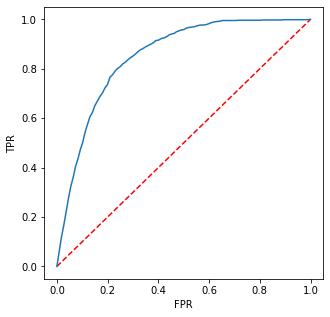

In [65]:
lrModel.summary.roc.select('FPR').collect()
lrModel.summary.roc.select('TPR').collect()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lrModel.summary.roc.select('FPR').collect(),
         lrModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [66]:
selected = lr_predictions.select("label", "prediction", "probability", "age", "work_type")
display(selected)
selected.show()

DataFrame[label: int, prediction: double, probability: vector, age: double, work_type: string]

+-----+----------+--------------------+----+-------------+
|label|prediction|         probability| age|    work_type|
+-----+----------+--------------------+----+-------------+
|    0|       1.0|[0.14602780295255...|80.0|Self-employed|
|    0|       1.0|[0.14602780295255...|80.0|Self-employed|
|    0|       0.0|[0.72531417687312...|44.0|      Private|
|    0|       0.0|[0.72531417687312...|44.0|      Private|
|    0|       0.0|[0.72531417687312...|44.0|      Private|
|    0|       1.0|[0.22294851009800...|79.0|      Private|
|    0|       1.0|[0.22294851009800...|79.0|      Private|
|    0|       0.0|[0.78761763347760...|44.0|      Private|
|    0|       0.0|[0.78761763347760...|44.0|      Private|
|    0|       0.0|[0.77373401919459...|36.0|     Govt_job|
|    0|       0.0|[0.77373401919459...|36.0|     Govt_job|
|    0|       0.0|[0.98608583141449...| 5.0|     children|
|    0|       0.0|[0.98869553306816...| 4.0|     children|
|    0|       0.0|[0.98657686264699...| 5.0|     childre

In [67]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(lr_predictions)

0.853291380344704

In [68]:
evaluator.getMetricName()

'areaUnderROC'

In [69]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train_data)

In [70]:
lr_cv_predictions = cvModel.transform(val_data)
evaluator.evaluate(lr_cv_predictions)


0.8532712826243123

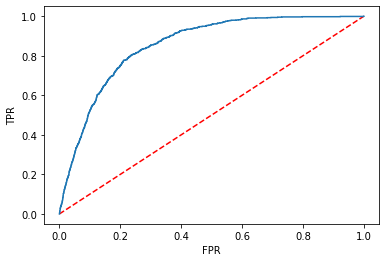

In [71]:
preds = lr_cv_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [72]:
test_lr_pred=lrModel.transform(testSet)
test_selected=test_lr_pred.select("id", "prediction", "probability", "age", "work_type")
test_selected.limit(5).toPandas()

,id,prediction,probability,age,work_type
0,36306,1.0,"[0.18304750126217392, 0.816952498737826]",80.0,Private
1,61829,1.0,"[0.1381652497823982, 0.8618347502176018]",74.0,Self-employed
2,14152,0.0,"[0.9765184165975913, 0.02348158340240865]",14.0,children
3,12997,0.0,"[0.9216438019894515, 0.07835619801054854]",28.0,Private
4,40801,0.0,"[0.5430128105966086, 0.4569871894033914]",63.0,Govt_job


# Decision Tree Classifier

Applying the machine learnings models in the Dataset. The following models are implemented as given below
1.Logistic Regression
2.Decision Tree Regression
3.RandomForest Regression


In [73]:
#Implementing DecisionTreeClassifier,RandomForrestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol = "features", labelCol = "label", maxDepth=10, maxBins=15)
dtModel = dtc.fit(train_data)

In [74]:
dtc_predictions = dtModel.transform(val_data)

In [75]:
dtc_predictions.select("prediction","probability", "label", "features").show(5)

+----------+--------------------+-----+--------------------+
|prediction|         probability|label|            features|
+----------+--------------------+-----+--------------------+
|       1.0|[0.15039304923458...|    0|[1.0,0.0,80.0,0.0...|
|       1.0|[0.15039304923458...|    0|[1.0,0.0,80.0,0.0...|
|       0.0|           [1.0,0.0]|    0|(11,[0,2,5,6,7,8]...|
|       0.0|           [1.0,0.0]|    0|(11,[0,2,5,6,7,8]...|
|       0.0|           [1.0,0.0]|    0|(11,[0,2,5,6,7,8]...|
+----------+--------------------+-----+--------------------+
only showing top 5 rows



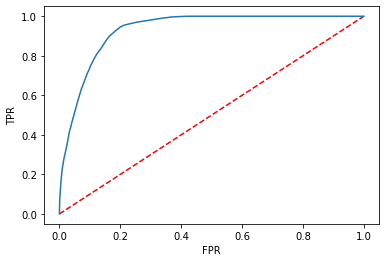

In [76]:
import matplotlib.pyplot as plt
preds = dtc_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [77]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator()
print("Test Area Under ROC:"+str(evaluator.evaluate(dtc_predictions,{evaluator.metricName:"areaUnderROC"})))


Test Area Under ROC:0.8553276014618657


In [78]:
evaluator.getMetricName()

'areaUnderROC'

In [79]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(dtc.maxDepth, [1, 2, 6, 10])
             .addGrid(dtc.maxBins, [20, 40, 80])
             .build())

In [80]:
cv = CrossValidator(estimator=dtc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train_data)
dtc_cv_predictions = cvModel.transform(val_data)
print("Test Area Under ROC after cross Validation:"+str(evaluator.evaluate(dtc_cv_predictions,{evaluator.metricName:"areaUnderROC"})))

Test Area Under ROC after cross Validation:0.8786553077161038


In [81]:
selected = dtc_cv_predictions.select("label", "prediction", "probability", "age", "work_type")
display(selected)
selected.show()

DataFrame[label: int, prediction: double, probability: vector, age: double, work_type: string]

+-----+----------+--------------------+----+-------------+
|label|prediction|         probability| age|    work_type|
+-----+----------+--------------------+----+-------------+
|    0|       1.0|[0.15549169859514...|80.0|Self-employed|
|    0|       1.0|[0.15549169859514...|80.0|Self-employed|
|    0|       0.0|           [1.0,0.0]|44.0|      Private|
|    0|       0.0|           [1.0,0.0]|44.0|      Private|
|    0|       0.0|           [1.0,0.0]|44.0|      Private|
|    0|       1.0|[0.25128122998078...|79.0|      Private|
|    0|       1.0|[0.25128122998078...|79.0|      Private|
|    0|       0.0|[0.87851176917236...|44.0|      Private|
|    0|       0.0|[0.87851176917236...|44.0|      Private|
|    0|       0.0|[0.80527431127854...|36.0|     Govt_job|
|    0|       0.0|[0.80527431127854...|36.0|     Govt_job|
|    0|       0.0|           [1.0,0.0]| 5.0|     children|
|    0|       0.0|           [1.0,0.0]| 4.0|     children|
|    0|       0.0|           [1.0,0.0]| 5.0|     childre

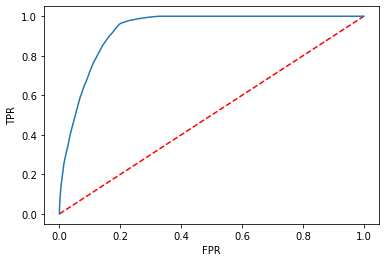

In [82]:
preds = dtc_cv_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [83]:
test_dtc_pred=dtModel.transform(testSet)
test_selected=test_dtc_pred.select("id", "prediction", "probability", "age", "work_type")
test_selected.limit(5).toPandas()

,id,prediction,probability,age,work_type
0,36306,1.0,"[0.15039304923458832, 0.8496069507654117]",80.0,Private
1,61829,1.0,"[0.16040955631399317, 0.8395904436860068]",74.0,Self-employed
2,14152,0.0,"[1.0, 0.0]",14.0,children
3,12997,0.0,"[1.0, 0.0]",28.0,Private
4,40801,0.0,"[1.0, 0.0]",63.0,Govt_job


# Random Forest Classification

In [84]:
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(labelCol="label", featuresCol="features",numTrees=5)
rfcModel = rfc.fit(train_data)
rfc_predictions = rfcModel.transform(val_data)

In [85]:
selected = rfc_predictions.select("label", "prediction", "probability", "age", "work_type")
display(selected)

DataFrame[label: int, prediction: double, probability: vector, age: double, work_type: string]

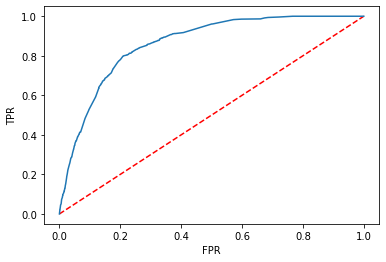

In [86]:
preds = rfc_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')
plt.figure()
plt.plot([0, 1], [0, 1], 'r--')
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [87]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(rfc_predictions)

0.861053754418822

In [88]:
evaluator.getMetricName()

'areaUnderROC'

In [89]:
paramGrid = (ParamGridBuilder()
             .addGrid(rfc.maxDepth, [2, 4, 6])
             .addGrid(rfc.maxBins, [20, 60])
             .addGrid(rfc.numTrees, [5, 20])
             .build())

cv = CrossValidator(estimator=rfc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train_data)

In [90]:
rfc_cv_predictions = cvModel.transform(val_data)
evaluator.evaluate(rfc_cv_predictions)

0.8827689728862722

In [91]:
selected = rfc_cv_predictions.select("label", "prediction", "probability", "age", "work_type")
display(selected)
selected.show()

DataFrame[label: int, prediction: double, probability: vector, age: double, work_type: string]

+-----+----------+--------------------+----+-------------+
|label|prediction|         probability| age|    work_type|
+-----+----------+--------------------+----+-------------+
|    0|       1.0|[0.17490681145833...|80.0|Self-employed|
|    0|       1.0|[0.17490681145833...|80.0|Self-employed|
|    0|       0.0|[0.83493837894196...|44.0|      Private|
|    0|       0.0|[0.83493837894196...|44.0|      Private|
|    0|       0.0|[0.83493837894196...|44.0|      Private|
|    0|       1.0|[0.21895046908904...|79.0|      Private|
|    0|       1.0|[0.21895046908904...|79.0|      Private|
|    0|       0.0|[0.82201749115584...|44.0|      Private|
|    0|       0.0|[0.82201749115584...|44.0|      Private|
|    0|       0.0|[0.83146303980536...|36.0|     Govt_job|
|    0|       0.0|[0.83146303980536...|36.0|     Govt_job|
|    0|       0.0|[0.93142602426107...| 5.0|     children|
|    0|       0.0|[0.94314633668091...| 4.0|     children|
|    0|       0.0|[0.94129740207809...| 5.0|     childre

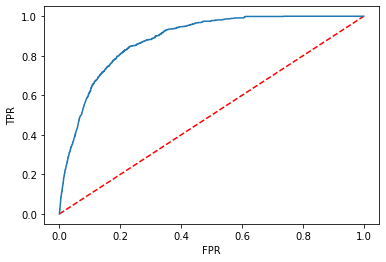

In [92]:
preds = rfc_cv_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

In [93]:
test_rfc_pred=rfcModel.transform(testSet)
test_selected=test_rfc_pred.select("id", "prediction", "probability", "age", "work_type")
test_selected.limit(5).toPandas()

,id,prediction,probability,age,work_type
0,36306,1.0,"[0.25063664393635454, 0.7493633560636455]",80.0,Private
1,61829,1.0,"[0.1498685539517343, 0.8501314460482657]",74.0,Self-employed
2,14152,0.0,"[0.88846193378145, 0.11153806621855]",14.0,children
3,12997,0.0,"[0.9195355348359179, 0.08046446516408219]",28.0,Private
4,40801,1.0,"[0.47090628407484647, 0.5290937159251535]",63.0,Govt_job


In [95]:
endTimeQuery = time.clock()
runTimeQuery = endTimeQuery - startTimeQuery
print(runTimeQuery)

1927.7977682000003
